In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

from dotenv import load_dotenv
load_dotenv()
DATASET_PATH=os.getenv("DATASET_DIRECTORY")
CONFIG_DIRECTORY = os.getenv("CONFIG_DIRECTORY")
RADVEL_MODEL_STATE_DICT_PATH=os.getenv("RADVEL_MODEL_STATE_DICT_PATH")
MODEL_TRAINING_DATASET_PATH=os.getenv("MODEL_TRAINING_DATASET_PATH")
GENERATED_DATASETS_PATH=os.getenv("GENERATED_DATASETS_PATH")


sys.path.append("../")
from mmwave_radar_processing.config_managers.cfgManager import ConfigManager
from cpsl_datasets.cpsl_ds import CpslDS

from mmwave_model_integrator.input_encoders.radvel_encoder import RadVelEncoder
from mmwave_model_integrator.ground_truth_encoders.radvel_gt_encoder import RadVelGTEncoder
from mmwave_model_integrator.plotting.plotter_doppler_az_to_vel import PlotterDopplerAzToVel
from mmwave_model_integrator.dataset_generators.doppler_az_to_vel_dataset_generator import DopplerAzToVelDatasetGenerator
from mmwave_model_integrator.model_runner.radvel_runner import RadVelRunner
from mmwave_model_integrator.decoders._decoder import _Decoder

#load possible model types
from mmwave_model_integrator.torch_training.models.Radarize_models import ResNet18,ResNet18Micro,ResNet18Nano,ResNet50

#load transformations
from torchvision.transforms import ToTensor,Resize

from mmwave_model_integrator.plotting.movie_generator_dop_az_to_pc import MovieGeneratorRngAzToPC
# from mmwave_model_integrator.analyzers.analyzer_rng_az_to_pc import AnalyzerRngAzToPC
# from mmwave_model_integrator.transforms.coordinate_transforms import polar_to_cartesian


/home/david/.cache/pypoetry/virtualenvs/mmwave-model-integrator-S4Y7oiM5-py3.12/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
#setup the config manager
cfg_manager = ConfigManager()

cfg_path = os.path.join(CONFIG_DIRECTORY,"RadVel.cfg")
cfg_manager.load_cfg(cfg_path)
cfg_manager.compute_radar_perforance(profile_idx=0)

In [3]:
#determine the paths to all of the datasets
dataset_name = "NORTH_RadVel_Test_1"
dataset_path = os.path.join(MODEL_TRAINING_DATASET_PATH,dataset_name)

#load the dataset
dataset = CpslDS(
    dataset_path=dataset_path,
    radar_folder="radar_0_adc",
    lidar_folder="lidar",
    camera_folder="camera",
    imu_orientation_folder="imu_data",
    imu_full_folder="imu_data_full",
    vehicle_odom_folder="vehicle_odom"
)

found 580 radar samples
found 580 lidar samples
found 580 camera samples
did not find imu (orientation) samples
did not find imu (full data) samples
found 580 vehicle velocity samples
found 580 vehicle odometry samples


In [4]:
plotter = PlotterDopplerAzToVel()

input_encoder = RadVelEncoder(
    config_manager=cfg_manager,
    num_angle_bins=64,
    min_power_threshold_dB=40
)

ground_truth_encoder = RadVelGTEncoder()

runner = RadVelRunner(
    model=ResNet18Nano(
        n_channels=1,
        n_outputs=2
    ),
    state_dict_path="/home/david/Documents/mmwave_model_integrator/notebooks/working_dir/RadVel.pth",
    cuda_device="cpu",
    transforms=[Resize(size=(64,64))]
)


decoder = _Decoder()

movie_generator = MovieGeneratorRngAzToPC(
    cpsl_dataset=dataset,
    plotter=plotter,
    input_encoder=input_encoder,
    runner=runner,
    decoder=decoder,
    ground_truth_encoder=ground_truth_encoder,
    temp_dir_path=os.getenv("MOVIE_TEMP_DIRECTORY")
)

# analyzer = AnalyzerRngAzToPC(
#     cpsl_dataset=dataset,
#     input_encoder=input_encoder,
#     model_runner=runner,
#     prediction_decoder=prediction_decoder,
#     ground_truth_encoder=ground_truth_encoder,
#     temp_dir_path=os.getenv("ANALYZER_TEMP_DIRECTORY")
# )

_ModelRunner: using CPU
Total number of parameters: 151362
creating temp directory: /home/david/Downloads/radvel_temp_dir


[ 0.45282382 -0.24649352]


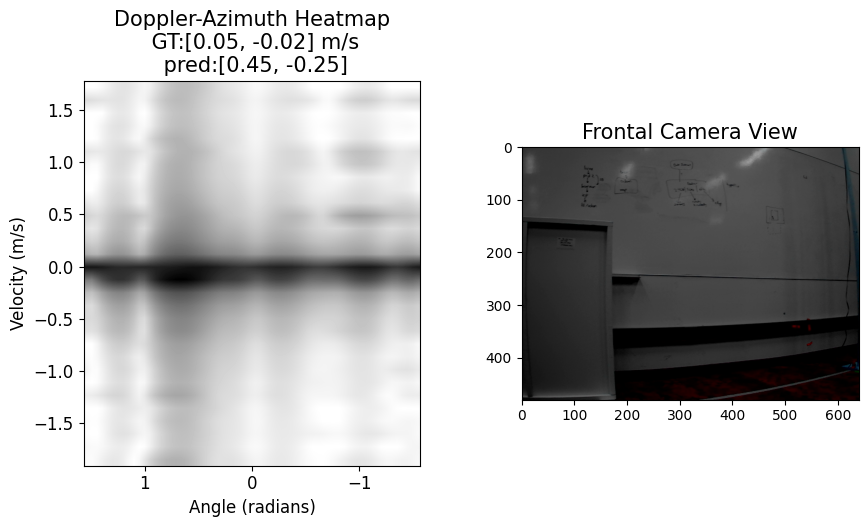

In [5]:
#plot a sample of the input/output for training
idx = 300
adc_cube = dataset.get_radar_data(idx)
odom = dataset.get_vehicle_odom_data(idx)

resp = input_encoder.encode(adc_cube)
pred = runner.make_prediction(resp)
print(pred)
#get camera data
try:
    camera_view = dataset.get_camera_frame(idx)
except AssertionError:
    camera_view = np.empty(shape=(0))

plotter.plot_compilation(
    input_data=adc_cube,
    input_encoder=input_encoder,
    gt_data=odom,
    ground_truth_encoder=ground_truth_encoder,
    runner=runner,
    decoder=decoder,
    camera_view=camera_view,
    axs=[],
    show=True
)

In [6]:
#speed comparison
from tqdm import tqdm

for i in tqdm(range(dataset.num_frames)):

    adc_cube = dataset.get_radar_data(idx=1)
    resp = input_encoder.encode(adc_cube)
    pred = runner.make_prediction(input=resp)

100%|██████████| 580/580 [00:02<00:00, 216.65it/s]


In [7]:
# chamfer,hausdorff, chamfer_radarHD, modified_hausdorff_radarHD = \
#     analyzer.compute_all_distance_metrics(
#         save_to_file=True,
#         file_name=dataset_name
#     )
# analyzer.show_all_summary_statistics(
#     chamfer_distances=chamfer,
#     hausdorff_distances=hausdorff,
#     chamfer_distances_radarHD=chamfer_radarHD,
#     modified_hausdorff_distances_radarHD=modified_hausdorff_radarHD
# )

In [8]:
# plotter.plot_distance_metrics_cdfs(
#     chamfer_distances=chamfer,
#     hausdorf_distances=hausdorff,
#     chamfer_distances_radarHD=chamfer_radarHD,
#     modified_hausdorf_distances_radarHD=modified_hausdorff_radarHD
# )

100%|██████████| 579/579 [00:17<00:00, 32.71it/s]


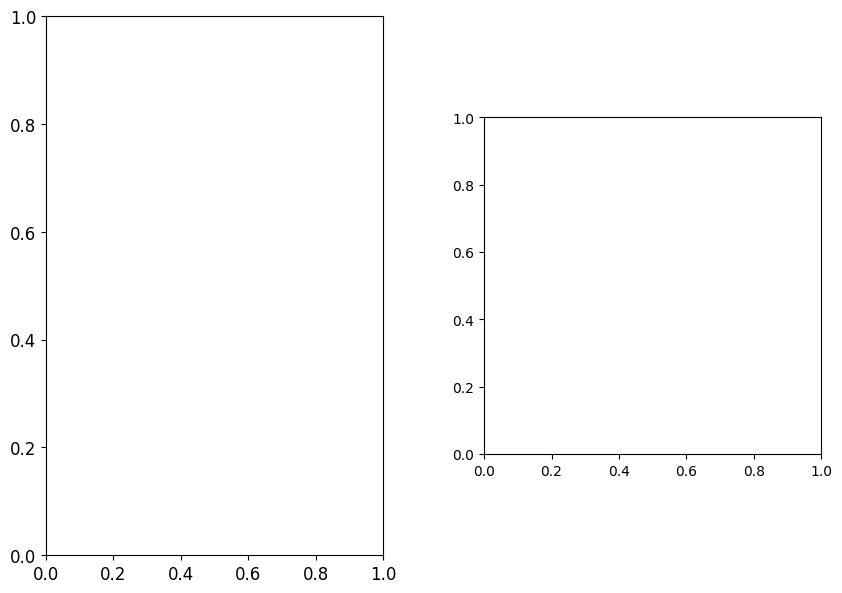

In [9]:
movie_generator.initialize_figure(
    nrows=1,
    ncols=2,
    figsize=(10,7),
    wspace=0.3,
    hspace=0.3
)

movie_generator.generate_movie_frames()

fps = 1 / (1e-3 * cfg_manager.frameCfg_periodicity_ms)
movie_generator.save_movie(video_file_name="{}.mp4".format(dataset_name),fps=fps)